In [1]:
#Python 3.7 is required 
import sys
#assert sys.version>="3.7"

#Tensorflow >=2.0 is required 
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPooling2D, Dropout
#assert tf.__version__>="2.0"

#chek matplotlib version
import matplotlib.pyplot as plt
import matplotlib as mpl
assert mpl.__version__>"3.2"

import os
import time
import math
import h5py
import numpy as np
import seaborn as sns
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # Set default figure size

In [2]:
tf.__version__

'1.15.0'

In [ ]:
# Check gpu devices 
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
if tf.config.list_physical_devices('GPU'):
    print('{} GPU device detected'.format(len(tf.config.list_physical_devices('GPU'))))
    print('Device name: {}'.format(local_device_protos[1].name))
    print('Physical device description: {}'.format(local_device_protos[1].physical_device_desc))

#### Load Data
Load greyscale images from .h5 file

In [2]:
h5f = h5py.File('data/SVHN_single_grey_2.h5', 'r')

In [3]:
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_test2 = h5f['X_test2'][:]
y_test2 = h5f['y_test2'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)
print('Test set2', X_test2.shape, y_test2.shape)


Training set (548961, 32, 32, 1) (548961, 10)
Validation set (5490, 32, 32, 1) (5490, 10)
Test set (24288, 32, 32, 1) (24288, 10)
Test set2 (90, 32, 32, 1) (90, 10)


#### Data Dimension

In [4]:
# size of image in training set
img_size = X_train.shape[1]

#number of channels in each image
num_channels = X_train.shape[-1]

#number of total images 
num_classes = y_train.shape[1]

#### Preprocessing

Apply mean subtraction and std normalization to our images.

In [5]:
#calculate mean on the training data 
train_mean = np.mean(X_train, axis=0)

#calculate std on the training data 
train_std = np.std(X_train, axis=0)

#subtract mean from all splits and normalize 
X_train = (X_train-train_mean)/train_std
X_test = (X_test-train_mean)/train_std
X_test2 = (X_test2-train_mean)/train_std
X_val = (train_mean-X_val)/train_std

### Helper functions

Let's implement some helper functions to make our notebook easier to read and reduce code duplication.

#### Helper function for plotting images

Here is a simple helper function that will help us plot ``nrows`` * ``ncols`` images with their true labels, and predicted labels - if passed to the function.

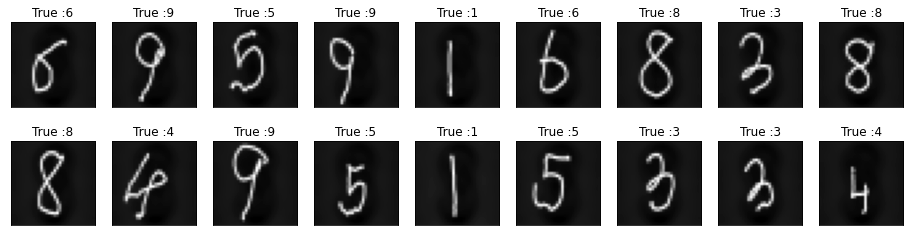

In [6]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    '''
        plot nrows*ncols images with true labels and predicted labels
        
    '''
    
    # Initiaize the subplotgrid
    fig, axes = plt.subplots(nrows,ncols)
    
    # Randomly select nrow*ncols images 
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axis object in the grid  
    for i, ax in zip(rs, axes.flat):
        
        # If class prediction not passed 
        if cls_pred is None:
            title = 'True :{0}'.format(np.argmax(cls_true[i]))
        
        # When prediction are passed, display labels and prediction in title
        else:
            title = 'True:{0}, Pred:{0}'.format(np.argmax(cls_true[i]), cls_pred[i])
    
        # Disply images
        ax.imshow(images[i,:,:,0], cmap='binary')
        
        
        #set title
        ax.set_title(title)
        
        #set ticks to none
        ax.set_xticks([])
        ax.set_yticks([])

# Plot 2 rows with 9 images each from the test2 set
plot_images(X_test2, 2, 9, y_test2);

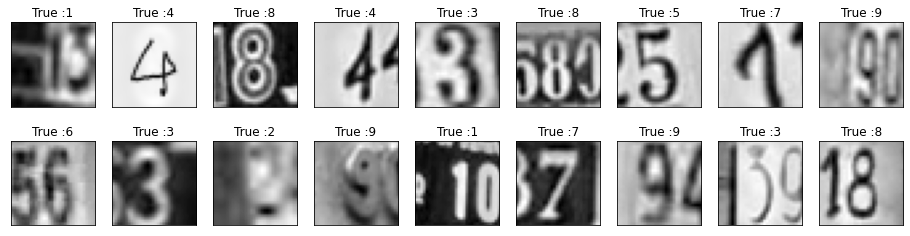

In [8]:
# Plot 2 rows with 9 images each from the test2 set
plot_images(X_val, 2, 9, y_val);

In [10]:
#tf.keras.backend.clear_session()
#tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(64, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="nadam",
              metrics=['categorical_accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
model.evaluate(X_test2, y_test2)

NameError: name 'MaxPool2D' is not defined

In [54]:
model.evaluate(X_test, y_test)

24288/24288 [==============================] - 6s 235us/sample - loss: 0.2761 - categorical_accuracy: 0.9303


[0.27611889228686737, 0.9302948]

In [55]:
model.save('digit_model_tf2.h5')

Use `tf.data` to batch and shuffle the data

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(1000).batch(16)
test2_ds = tf.data.Dataset.from_tensor_slices((X_test2, y_test2)).shuffle(1000).batch(16)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(1000).batch(64)

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing):

In [10]:
class NumNet(Model):
    
    def __init__(self):
        super(NumNet, self).__init__()
        
        self.Conv1 = Conv2D(16, 3, activation='relu', padding='same', strides =(1,1))
        self.Conv2 = Conv2D(32, 3, activation ='relu', padding='same',strides =(1,1))
        self.Conv3 = Conv2D(64, 3, activation = 'relu', padding='same', strides =(1,1))
        self.pool = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')
        self.flatten = Flatten()
        self.dense1 = Dense(512, activation='relu', use_bias=True, kernel_initializer='glorot_uniform')
        self.dense2 = Dense(10, activation='softmax')
        self.dropout = Dropout(rate=0.5)
        
        
    def call(self, x):
        
        x = self.Conv1(x)
        x = self.pool(x)
        x = self.Conv2(x)
        x = self.pool(x)
        x = self.Conv3(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

#create an instance of model
model = NumNet()

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,name='categorical_crossentropy'),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "num_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  160       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4640      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  524800    
_________________________________________________________________
dense_1 (Dense)              multiple                  5130

In [11]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False,name='categorical_crossentropy')

optimizer = tf.keras.optimizers.Adam()

In [12]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [19]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    print('In train')
    train_loss(loss)
    train_accuracy(labels, predictions)

In [20]:
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    print('In test')
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [21]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

for test_images, test_labels in test_ds2:
    test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))

In train
In train


KeyboardInterrupt: 